In [1]:
!pip install tensorflow==2.4.2

     |████████████████████████████████| 394.5MB 38kB/s 
     |████████████████████████████████| 2.9MB 38.7MB/s 
     |████████████████████████████████| 471kB 31.2MB/s 
     |████████████████████████████████| 3.8MB 30.6MB/s 
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [2]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!pip install import-ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=24a5a6c6caceb43f36bf62554e804d0a5a7c54d933f149d7e8d50d7adce048bd
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [4]:
%cd "drive/MyDrive/Bionformatics_Project/Colab"

/content/drive/.shortcut-targets-by-id/1he9S1Es-XalZ9vgCRMbTTNd6cXeRkkFI/Bionformatics_Project/Colab


In [5]:
from Classes.DataManager import DataManager
from Classes.Transformer import projTransformer
from tensorflow import keras
import tensorflow as tf
import numpy as np

%load_ext tensorboard
model = tf.keras.models.load_model('Saved_Models/top_transformers/top_transformer_2')

importing Jupyter notebook from /content/drive/.shortcut-targets-by-id/1he9S1Es-XalZ9vgCRMbTTNd6cXeRkkFI/Bionformatics_Project/Colab/Classes/DataManager.ipynb
importing Jupyter notebook from /content/drive/.shortcut-targets-by-id/1he9S1Es-XalZ9vgCRMbTTNd6cXeRkkFI/Bionformatics_Project/Colab/Classes/Transformer.ipynb
Populating the interactive namespace from numpy and matplotlib
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 10500)]      0                                            
__________________________________________________________________________________________________
token_and_position_embedding_4  (None, 10500, 32)    336128      input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 10500, 32)    6176        token_and_position_embedding_4[0]
__________________________________________________________________________________________________
average_pooling1d_12 (AveragePo (None, 350, 32)      0           conv1d_8[0][0]                   
____________________________________________________________________________________________

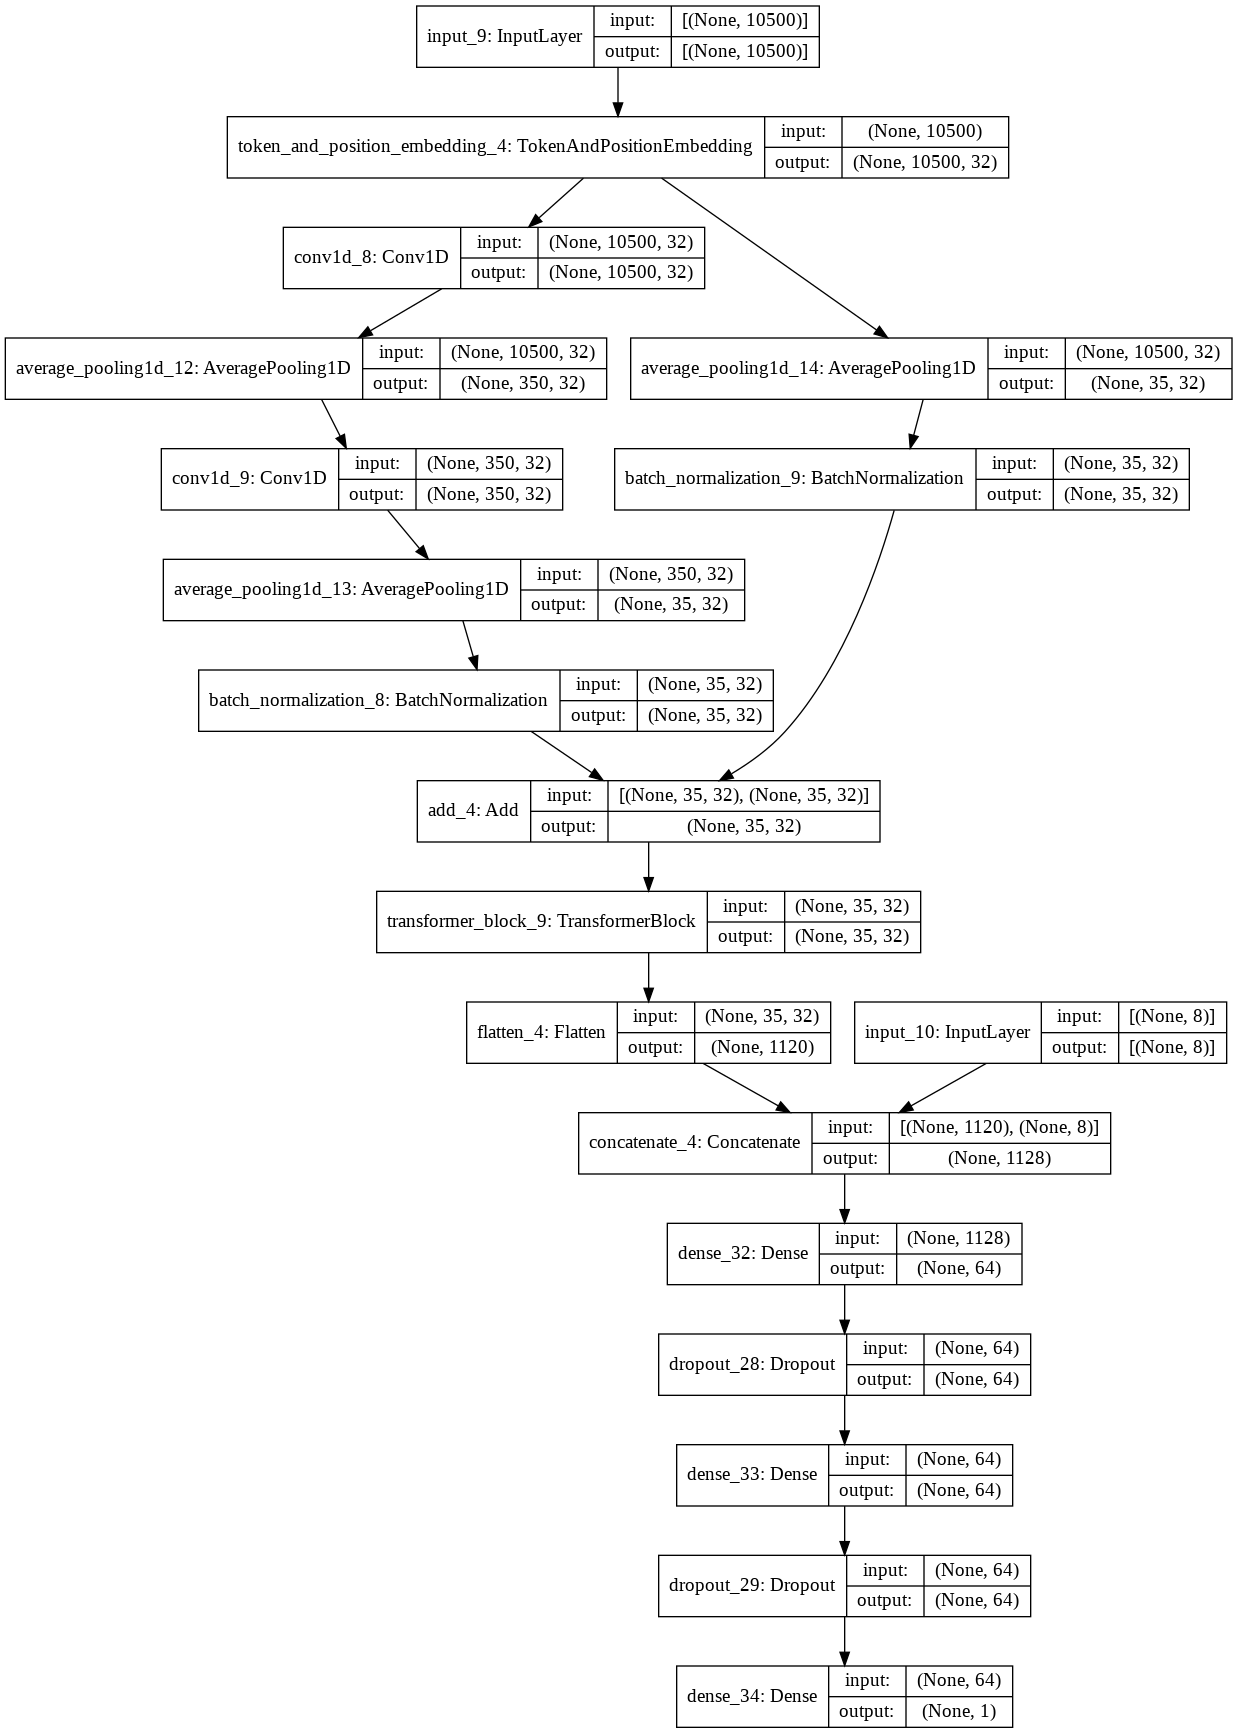

In [6]:
model.summary()
img = tf.keras.utils.plot_model(model, "BestTransformer.png", show_shapes=True)
display(img)

data loading takes at most 30s, we can improve it saving the numerical representation of sequences

In [7]:
print("> Loading DataManager...")
dm = DataManager(transformer=True, remove_indicted=True)

print("> Loading train data...")
X_trainhalflife, X_trainpromoter, y_train, geneName_train = dm.get_train(True, True)

print("> Loading validation data...")
X_validationhalflife, X_validationpromoter, y_validation, geneName_validation, _ = dm.get_validation(True, True)

print("> Loading test data...")
X_testhalflife, X_testpromoter, y_test, geneName_test = dm.get_test(True, True)

print("\n**************\n     DONE\n**************\n")

> Loading DataManager...
> Loading train data...
> Loading validation data...
> Loading test data...

**************
     DONE
**************



Preprocessing-> Padding

In [8]:
leftpos  = 9_500          #3_000 
rightpos = 20_000         #13_500
maxlen   = rightpos-leftpos
print("maxlen: ",maxlen)

maxlen:  10500


In [10]:
X_trainpromoter_p      = keras.preprocessing.sequence.pad_sequences(X_trainpromoter,      maxlen=maxlen)
X_validationpromoter_p = keras.preprocessing.sequence.pad_sequences(X_validationpromoter, maxlen=maxlen)
X_testpromoter_p       = keras.preprocessing.sequence.pad_sequences(X_testpromoter,       maxlen=maxlen)

In [11]:
import tensorflow as tf
from scipy import stats
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

model = tf.keras.models.load_model('Saved_Models/top_transformers/top_transformer_2')
predictions = model.predict([X_testpromoter_p, X_testhalflife]).flatten()
slope, intercept, r_value, p_value, std_err = stats.linregress(predictions, y_test)
print('Test R^2 = %.3f' % r_value**2)

Test R^2 = 0.614


No handles with labels found to put in legend.


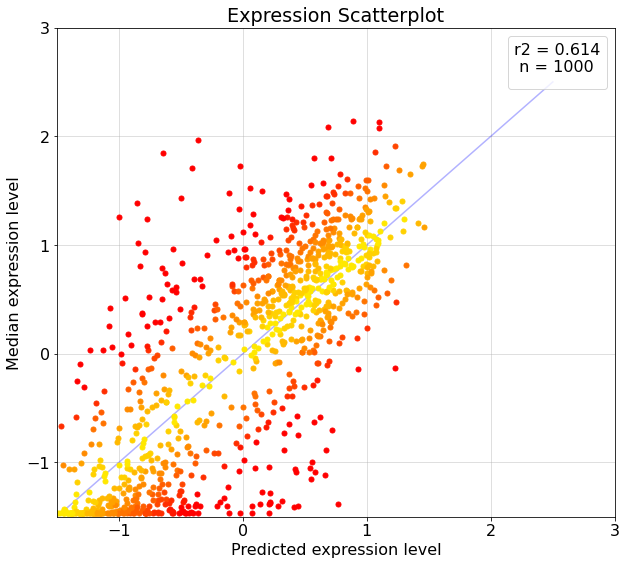

In [12]:
viridis = cm.get_cmap('autumn', 12)
diff = y_test - predictions
diff = np.abs(diff)

### plt size
plt.rcParams["figure.figsize"] = (10,9)
### plt fontsize
plt.rcParams.update({'font.size': 16})

### set title
plt.title("Expression Scatterplot")
### plot
bis = np.arange(-1.5, 3, 2)
plt.plot(bis, bis,  f"b", alpha=0.3)
for p, yi, c in zip(predictions, y_test, diff):
    plt.plot(p, yi,  f".", markersize=10, color=viridis((1.0-c)/1.1))
### set ticks
plt.xticks([i for i in range(-1, 4)])
plt.yticks([i for i in range(-1, 4)])
### set labels
plt.xlabel("Predicted expression level")
plt.ylabel("Median expression level")
### create legend
plt.legend(loc="upper right", title=f"r2 = %.3f\n n = 1000" % r_value**2)
### set ylim
plt.ylim((-1.5,3))
plt.xlim((-1.5,3))
### grid
plt.grid(alpha=0.5)
plt.show()

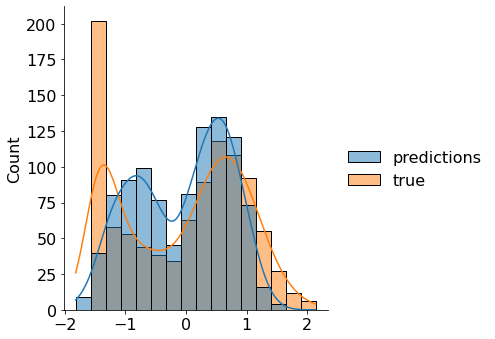

In [13]:
df = pd.DataFrame({"predictions":predictions, "true":y_test})
ax = sns.displot(data=df, kde=True)
plt.show()